# Women in Public Policy and Mathematics Workshop 2019
## Downscaling climate data using machine learning
### Research question: Can machine learning techniques downscale climate data to individual weather observation stations?
### Project Lead: Cecilia Bitz
### Project Participants: Amanda Back, Katie Brennan, Oriana Chegwidden, Mimi Hughes, Marielle Pinheiro, Kristin Van Abel

Supported by the Institute for Pure and Applied Mathematics, The Rand Corporation, and the Luskin Center at UCLA

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xarray as xr
from netCDF4 import Dataset

In [2]:
def load_eofs(filename):
    '''
    Load EOFs constructed by CC located on cheyenne
    '''
    ds = Dataset(filename, 'r')
    neof = np.arange(20)
    times = np.arange(1980,2018)
    pcs = np.array(ds.variables['pc'][:])
    df = pd.DataFrame(pcs, index=times)
    return df

In [3]:
def load_temp_data(filename):
    '''
    Load temperature observation files located on Cheyenne to produce 
    '''
    square_df = pd.read_csv(filename, index_col='year')
    square_df = square_df.drop(columns=['lat', 'lon'])
    return square_df

In [4]:
def remove_climatology(square_df):
    '''
    Return a dataframe that removes the climatology 
    from the existing dataframe'''
    average_seasonal_cycle = square_df.mean(axis=0)[0:12]
    square_df = square_df - average_seasonal_cycle
    return square_df

In [5]:
def create_single_timeseries(square_df):
    '''
    Read in a data frame which is month x year and produce one
    which is a single timeseries
    '''
    df = pd.Series(square_df.values.ravel(), 
                   index=pd.date_range('1979-01', '2018-01', freq='M'))
    df = df.truncate(before='1979-10-01', after='2017-10-01')
    return df

CC did a principle components analysis (PCA) on the ERAinterim reanalysis temperature product and found the 20 modes of variability across the western US. She then created a file including the weights of each of those PCs for every month of the year for the reanalysis period of record. Let's load those into a data frame!

In [7]:
pc_file = '/gpfs/fs1/work/bitz/WPO2019/PrepareERAiT2m/T2m_ERAi_inputs_1980to2017WaterYear.csv'
features = pd.read_csv(pc_file)
features.index = pd.date_range(start='10-1979', end='10-2017', freq='M')

Let's also do a little formatting to make the data frame that houses the PCs a little neater

In [8]:
column_names = []
for i in range(1,21):
    column_names.append('pc'+str(i))
column_names.append('RegionalMean')
index = pd.date_range(start='10-01-1979', end='10-01-2017', freq='M')
features = pd.DataFrame(data=features[column_names].values, columns=column_names, index=index)

Add the observations into the same data frame

In [28]:
station_list = ['GUC', 'AFF']
targets = pd.DataFrame(columns=station_list, index=features.index)
for station in station_list:
    filename = '/glade/work/acback/WPO2019/%s.csv' % station
    targets[station] = create_single_timeseries(
                            remove_climatology(load_temp_data(filename)))

We'll divide the record into a training period and a test period. The training period (which ends at the `split_date`) will be used to train the machine learning model. That model will then be evaluated by using the data from the test period (the period after the `split_date`). 

In [29]:
split_date = '2004-10-01'

features_train = features.truncate(after=split_date)
features_test = features.truncate(before=split_date)
targets_train = targets.truncate(after=split_date)
targets_test = targets.truncate(before=split_date)

# Now let's get into the machine learning piece!
## Random forest 

First, instantiate model specifying any parameters you might be interested in.


In [30]:
rf = RandomForestRegressor(n_estimators=1000, random_state=41)

Then, train the model on your specified selection of training data

In [31]:
rf.fit(features_train.values , targets_train.values.squeeze());

Finally, try out the trained model using the data you have reserved for testing (and add it back into your original dataframe).

In [32]:
predictions = rf.predict(features_test)

How well did you do? Let's check out the R^2!

In [33]:
test_r2 = rf.score(features_test, targets_test)
train_r2 = rf.score(features_train, targets_train)
print('Training R^2 is: %s' % train_r2)
print('Test R^2 is: %s' % test_r2)

Training R^2 is: 0.8719685615158339
Test R^2 is: -1.0459673132084661


In [34]:
predictions = pd.DataFrame(predictions, columns=targets_test.columns, index=targets_test.index)

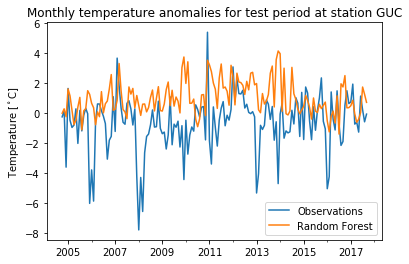

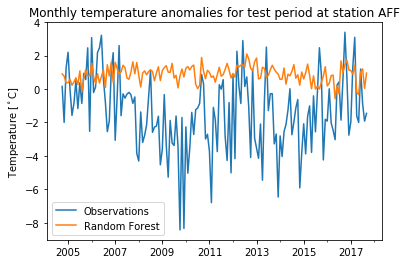

In [35]:
for station in station_list:
    plt.figure()
    targets_test[station].plot(label='Observations')
    predictions[station].plot(label='Random Forest')
    plt.ylabel('Temperature [$^\circ$C]')
    plt.legend()
    plt.title('Monthly temperature anomalies for test period at station %s' % station)
    plt.savefig('comparing_methods_%s_January.png' % station, dpi=250)

In [ ]:
rf.feature_importances_

## Visualizing a Single Decision Tree

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = column_names, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

# Now let's make a baseline: pure interpolation